# Packages

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

import geopandas as gpd
import fiona
import shapely

fpath = 'geopandas_data/geopandas/data'

import os
os.getcwd()

'c:\\Users\\gilramolete\\OneDrive - UNIONBANK of the Philippines\\Documents 1\\Geospatial Analysis\\Geospatial Data Science with Python - Geopandas'

# Clipping in GeoPandas

Two ways: one is by intersection.

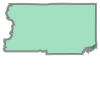

In [72]:
counties = gpd.read_file(f"{fpath}/colorado_counties.shp")
raptors = gpd.read_file(f"{fpath}/Raptor_Nests.shp")
boulder_county = counties[counties['NAMELSAD10']=='Boulder County'].unary_union
boulder_county

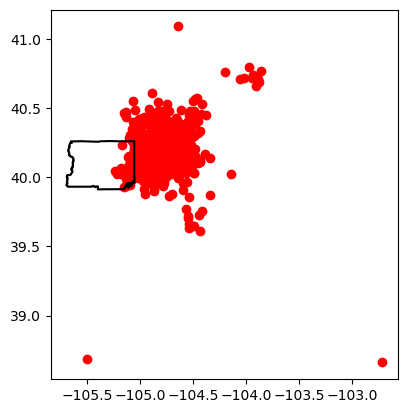

In [73]:
basemap = counties[counties['NAMELSAD10'] =='Boulder County'].boundary.plot(color = 'k')
raptors.plot(ax = basemap, color = 'red')
plt.show()

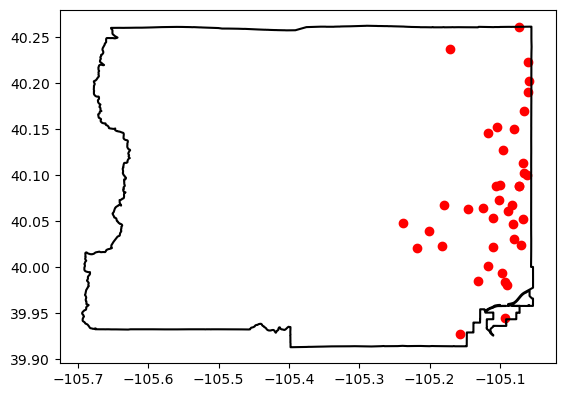

In [74]:
# Clip the raptor data out
boulder_nests = raptors[raptors['geometry'].intersects(boulder_county)]
basemap = counties[counties['NAMELSAD10'] =='Boulder County'].boundary.plot(color = 'k')
boulder_nests.plot(ax = basemap, color = 'red')
plt.show()

Can also use predicate, but we can get different results with polygons.

C:\Users\gilramolete\AppData\Local\Temp\ipykernel_33944\4290223659.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  raptors['buffer'] = raptors['geometry'].buffer(0.01)


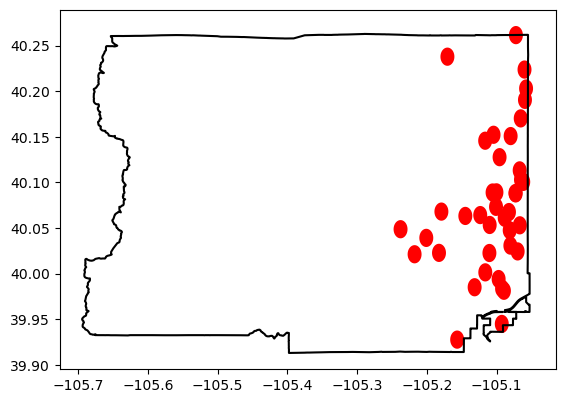

In [75]:
raptors['buffer'] = raptors['geometry'].buffer(0.01)
raptors.set_geometry('buffer', inplace = True)

boulder_nests = raptors[raptors['geometry'].intersects(boulder_county)]
basemap = counties[counties['NAMELSAD10'] =='Boulder County'].boundary.plot(color = 'k')
boulder_nests.plot(ax = basemap, color = 'red')
plt.show()

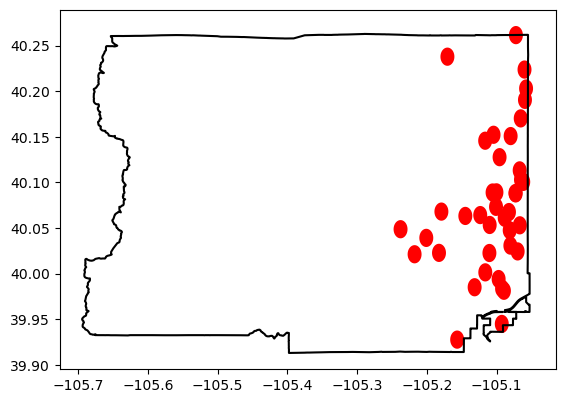

In [76]:
# With within predicate
boulder_nests = raptors[raptors['geometry'].within(boulder_county)]
basemap = counties[counties['NAMELSAD10'] =='Boulder County'].boundary.plot(color = 'k')
boulder_nests.plot(ax = basemap, color = 'red')
plt.show()

# Advanced Geometry Calculations

## Point geometries

In [77]:
raptor = gpd.read_file(f"{fpath}/Raptor_Nests.shp")
raptor.rename(inplace = True, columns = {"postgis_fi":"gid", "lat_y_dd":"latitude", "long_x_dd":"longitude"})
raptor.head()

,gid,latitude,longitude,lastsurvey,recentspec,recentstat,Nest_ID,geometry
0,361.0,40.267502,-104.870872,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,POINT (-104.79595 40.29891)
1,362.0,40.264321,-104.860255,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,POINT (-104.78897 40.22089)
2,1.0,38.650081,-105.494251,2014-07-28,Swainsons Hawk,INACTIVE NEST,1,POINT (-105.50223 38.68694)
3,2.0,40.309574,-104.932604,2011-01-06,Swainsons Hawk,INACTIVE NEST,2,POINT (-104.84889 40.35215)
4,3.0,40.219343,-104.729246,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,POINT (-104.74466 40.18571)


In [78]:
# Recalculate existing latitude and longitude columns
raptor['latitude'] = raptor['geometry'].x
raptor['longitude'] = raptor['geometry'].y

# Can also create new fields to hold coordinates in a different crs
raptor['northing_26913'] = raptor["geometry"].to_crs(epsg = 26913).y
raptor['easting_26913'] = raptor["geometry"].to_crs(epsg = 26913).x

raptor.head()

,gid,latitude,longitude,lastsurvey,recentspec,recentstat,Nest_ID,geometry,northing_26913,easting_26913
0,361.0,-104.79595,40.29891,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,POINT (-104.79595 40.29891),4.460954e+06,517341.522300
1,362.0,-104.78897,40.22089,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,POINT (-104.78897 40.22089),4.452295e+06,517955.324324
2,1.0,-105.50223,38.68694,2014-07-28,Swainsons Hawk,INACTIVE NEST,1,POINT (-105.50223 38.68694),4.282156e+06,456319.857904
3,2.0,-104.84889,40.35215,2011-01-06,Swainsons Hawk,INACTIVE NEST,2,POINT (-104.84889 40.35215),4.466854e+06,512832.261313
4,3.0,-104.74466,40.18571,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,POINT (-104.74466 40.18571),4.448400e+06,521736.623609


## Line geometries

In [79]:
linear = gpd.read_file(f'{fpath}/Linear_Projects.shp')
linear.head()

,postgis_fi,type,row_width,Project,geometry
0,50,Flowline,20.0,50,"LINESTRING (-104.59795 40.19258, -104.59739 40..."
1,67,Pipeline,50.0,67,"LINESTRING (-105.05555 40.06609, -105.05941 40..."
2,68,Pipeline,50.0,68,"LINESTRING (-105.04607 40.10830, -105.04566 40..."
3,69,Flowline,20.0,69,"LINESTRING (-104.83998 40.21731, -104.83930 40..."
4,70,Flowline,20.0,70,"LINESTRING (-104.77210 40.20982, -104.77193 40..."


In [80]:
# Work with shapely geometries in a custom function
# Can get complicated with MultiLineString geometries, in case the number of vertices of each
# LineString is summed up
def n_points(geom):
    if geom.type == 'LineString':
        return len(geom.coords)
    elif geom.type == 'MultiLineString':
        n_points = 0
        for part in geom.geoms:
            n_points += len(part.coords)
        return n_points
    else:
        return geom

linear['n_points'] = linear['geometry'].apply(n_points)
linear.sort_values('n_points')

,postgis_fi,type,row_width,Project,geometry,n_points
0,50,Flowline,20.0,50,"LINESTRING (-104.59795 40.19258, -104.59739 40...",2
651,649,Access Road - Estimated,20.0,649,"LINESTRING (-105.03634 39.96394, -105.03638 39...",2
648,646,Extraction,20.0,646,"LINESTRING (-104.69056 40.19208, -104.68759 40...",2
643,641,Access Road - Confirmed,20.0,641,"LINESTRING (-104.66251 40.14244, -104.66250 40...",2
641,639,Access Road - Confirmed,20.0,639,"LINESTRING (-104.62899 40.40126, -104.63138 40...",2
...,...,...,...,...,...,...
300,296,Pipeline,50.0,296,"LINESTRING (-104.92334 40.16080, -104.92333 40...",47
724,723,Access Road - Estimated,20.0,723,"LINESTRING (-104.60523 40.96910, -104.60312 40...",48
316,312,Pipeline,50.0,312,"MULTILINESTRING ((-104.81483 40.20081, -104.81...",51
733,732,Access Road - Estimated,20.0,732,"LINESTRING (-104.46589 40.98460, -104.46438 40...",53


In [83]:
# We can get first or last point in a LineString
def end_pt(geom):
    if geom.type == 'LineString':
        return geom.coords[-1]
    else:
        return geom

linear['end'] = linear['geometry'].apply(end_pt)
linear.sort_values('n_points')

c:\Users\gilramolete\Anaconda3\envs\pls\Lib\site-packages\pandas\core\dtypes\inference.py:387: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
c:\Users\gilramolete\Anaconda3\envs\pls\Lib\site-packages\pandas\core\dtypes\inference.py:388: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
c:\Users\gilramolete\Anaconda3\envs\pls\Lib\site-packages\pandas\io\formats\printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
c:\Users\g

,postgis_fi,type,row_width,Project,geometry,n_points,end
0,50,Flowline,20.0,50,"LINESTRING (-104.59795 40.19258, -104.59739 40...",2,"(-104.59739, 40.19223)"
651,649,Access Road - Estimated,20.0,649,"LINESTRING (-105.03634 39.96394, -105.03638 39...",2,"(-105.03638, 39.96427)"
648,646,Extraction,20.0,646,"LINESTRING (-104.69056 40.19208, -104.68759 40...",2,"(-104.68759, 40.19315)"
643,641,Access Road - Confirmed,20.0,641,"LINESTRING (-104.66251 40.14244, -104.66250 40...",2,"(-104.6625, 40.14321)"
641,639,Access Road - Confirmed,20.0,639,"LINESTRING (-104.62899 40.40126, -104.63138 40...",2,"(-104.63138, 40.40127)"
...,...,...,...,...,...,...,...
300,296,Pipeline,50.0,296,"LINESTRING (-104.92334 40.16080, -104.92333 40...",47,"(-104.78962, 40.19664)"
724,723,Access Road - Estimated,20.0,723,"LINESTRING (-104.60523 40.96910, -104.60312 40...",48,"(-104.59529, 41.00339)"
316,312,Pipeline,50.0,312,"MULTILINESTRING ((-104.81483 40.20081, -104.81...",51,"(LINESTRING (-104.81483 40.20081, -104.81536 4..."
733,732,Access Road - Estimated,20.0,732,"LINESTRING (-104.46589 40.98460, -104.46438 40...",53,"(-104.47219, 41.03218)"


## Linear referencing with Shapely

In [84]:
def mid_point(geom):
    return geom.interpolate(0.5, normalized = True)

linear['mid_pt2'] = linear['geometry'].apply(mid_point)
linear.sort_values('n_points')

c:\Users\gilramolete\Anaconda3\envs\pls\Lib\site-packages\pandas\core\dtypes\inference.py:387: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
c:\Users\gilramolete\Anaconda3\envs\pls\Lib\site-packages\pandas\core\dtypes\inference.py:388: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
c:\Users\gilramolete\Anaconda3\envs\pls\Lib\site-packages\pandas\io\formats\printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
c:\Users\g

,postgis_fi,type,row_width,Project,geometry,n_points,end,mid_pt2
0,50,Flowline,20.0,50,"LINESTRING (-104.59795 40.19258, -104.59739 40...",2,"(-104.59739, 40.19223)",POINT (-104.59767 40.19241)
651,649,Access Road - Estimated,20.0,649,"LINESTRING (-105.03634 39.96394, -105.03638 39...",2,"(-105.03638, 39.96427)",POINT (-105.03636 39.96411)
648,646,Extraction,20.0,646,"LINESTRING (-104.69056 40.19208, -104.68759 40...",2,"(-104.68759, 40.19315)",POINT (-104.68908 40.19262)
643,641,Access Road - Confirmed,20.0,641,"LINESTRING (-104.66251 40.14244, -104.66250 40...",2,"(-104.6625, 40.14321)",POINT (-104.66250 40.14283)
641,639,Access Road - Confirmed,20.0,639,"LINESTRING (-104.62899 40.40126, -104.63138 40...",2,"(-104.63138, 40.40127)",POINT (-104.63018 40.40126)
...,...,...,...,...,...,...,...,...
300,296,Pipeline,50.0,296,"LINESTRING (-104.92334 40.16080, -104.92333 40...",47,"(-104.78962, 40.19664)",POINT (-104.86792 40.18127)
724,723,Access Road - Estimated,20.0,723,"LINESTRING (-104.60523 40.96910, -104.60312 40...",48,"(-104.59529, 41.00339)",POINT (-104.57569 40.98647)
316,312,Pipeline,50.0,312,"MULTILINESTRING ((-104.81483 40.20081, -104.81...",51,"(LINESTRING (-104.81483 40.20081, -104.81536 4...",POINT (-104.82531 40.23243)
733,732,Access Road - Estimated,20.0,732,"LINESTRING (-104.46589 40.98460, -104.46438 40...",53,"(-104.47219, 41.03218)",POINT (-104.47374 41.00641)


## Geopandas Collect

In [85]:
raptor = gpd.read_file(f"{fpath}/Raptor_Nests.shp")
raptor.head()

,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry
0,361.0,40.267502,-104.870872,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,POINT (-104.79595 40.29891)
1,362.0,40.264321,-104.860255,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,POINT (-104.78897 40.22089)
2,1.0,38.650081,-105.494251,2014-07-28,Swainsons Hawk,INACTIVE NEST,1,POINT (-105.50223 38.68694)
3,2.0,40.309574,-104.932604,2011-01-06,Swainsons Hawk,INACTIVE NEST,2,POINT (-104.84889 40.35215)
4,3.0,40.219343,-104.729246,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,POINT (-104.74466 40.18571)


In [86]:
raptor['recentstat'].value_counts()

INACTIVE NEST         470
ACTIVE NEST           251
FLEDGED NEST          155
COULD NOT SEE NEST      3
Name: recentstat, dtype: int64

In [88]:
active_nests = raptor[raptor['recentstat'] == 'ACTIVE NEST']['geometry']
active_nests = gpd.tools.collect(active_nests)
active_nests.type

'MultiPoint'

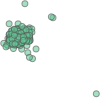

In [89]:
active_nests

In [90]:
# Convert all geometries to multitypes
raptor['geometry'] = gpd.tools.collect(raptor['geometry'], multi = True)
raptor.head()

,postgis_fi,lat_y_dd,long_x_dd,lastsurvey,recentspec,recentstat,Nest_ID,geometry
0,361.0,40.267502,-104.870872,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,"MULTIPOINT (-104.79595 40.29891, -104.78897 40..."
1,362.0,40.264321,-104.860255,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,"MULTIPOINT (-104.79595 40.29891, -104.78897 40..."
2,1.0,38.650081,-105.494251,2014-07-28,Swainsons Hawk,INACTIVE NEST,1,"MULTIPOINT (-104.79595 40.29891, -104.78897 40..."
3,2.0,40.309574,-104.932604,2011-01-06,Swainsons Hawk,INACTIVE NEST,2,"MULTIPOINT (-104.79595 40.29891, -104.78897 40..."
4,3.0,40.219343,-104.729246,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,"MULTIPOINT (-104.79595 40.29891, -104.78897 40..."


# EDA

In [91]:
raptor = gpd.read_file(f"{fpath}/Raptor_Nests.shp")
raptor.rename(inplace = True, columns = {"postgis_fi":"gid", "lat_y_dd":"latitude", "long_x_dd":"longitude"})
raptor.head()

,gid,latitude,longitude,lastsurvey,recentspec,recentstat,Nest_ID,geometry
0,361.0,40.267502,-104.870872,2012-03-16,Swainsons Hawk,INACTIVE NEST,361,POINT (-104.79595 40.29891)
1,362.0,40.264321,-104.860255,2012-03-16,Swainsons Hawk,INACTIVE NEST,362,POINT (-104.78897 40.22089)
2,1.0,38.650081,-105.494251,2014-07-28,Swainsons Hawk,INACTIVE NEST,1,POINT (-105.50223 38.68694)
3,2.0,40.309574,-104.932604,2011-01-06,Swainsons Hawk,INACTIVE NEST,2,POINT (-104.84889 40.35215)
4,3.0,40.219343,-104.729246,2014-07-03,Swainsons Hawk,ACTIVE NEST,3,POINT (-104.74466 40.18571)


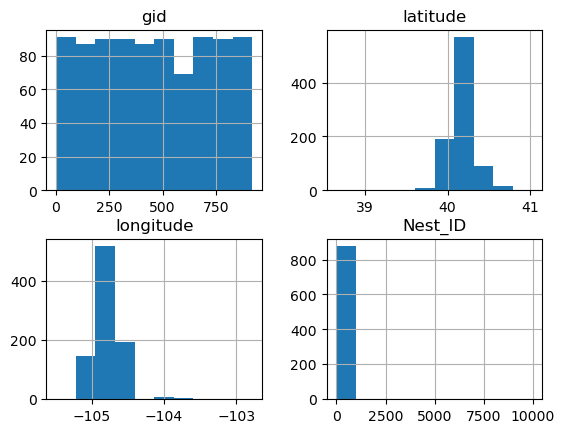

In [93]:
# Histogram
raptor.hist()
plt.show()

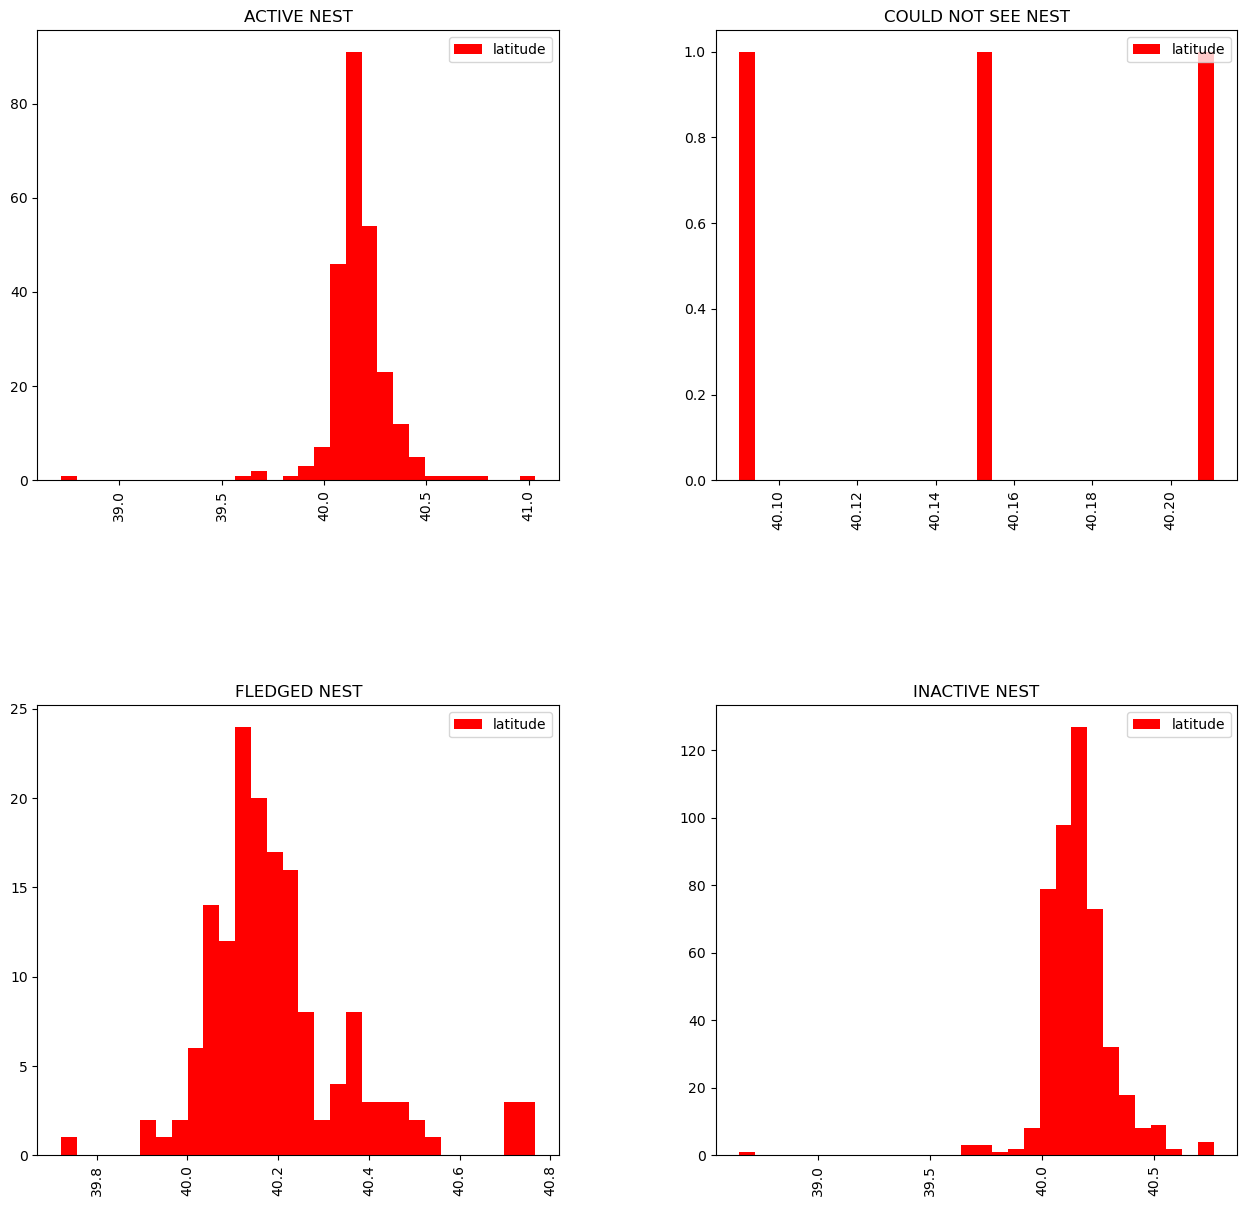

In [94]:
# Including parameters to limit what is shown in histogram
raptor.hist(column = 'latitude', by = 'recentstat',
            legend = True, bins = 30, figsize = (15, 15), color = 'red')
plt.show()

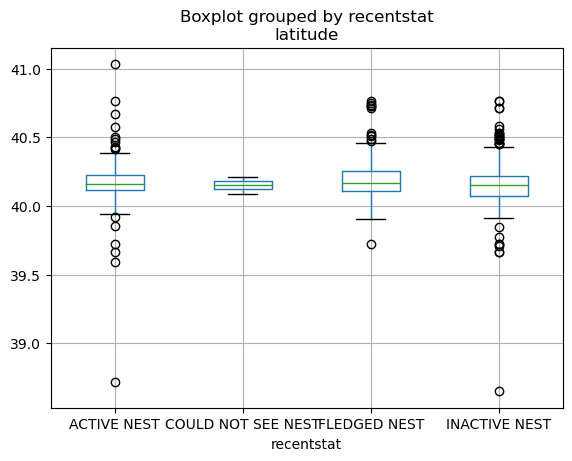

In [95]:
# Boxplot
raptor.boxplot(column = 'latitude', by = 'recentstat')
plt.show()

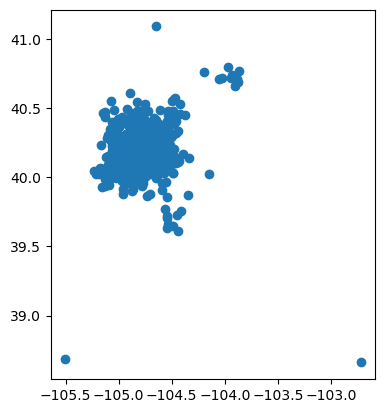

In [96]:
# Plotting map by default
raptor.plot()
plt.show()

<AxesSubplot: >

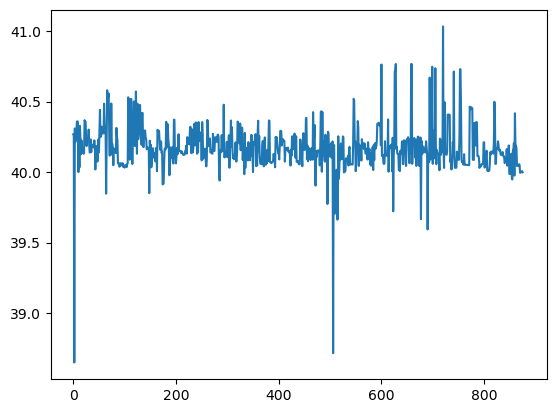

In [97]:
# Line graph
raptor['latitude'].plot()

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

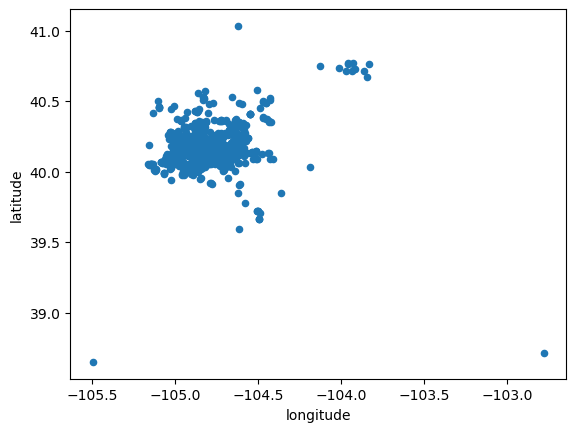

In [98]:
raptor[['longitude', 'latitude', 'recentstat']].plot.scatter(x='longitude', y='latitude')

In [99]:
stat_count = raptor[['longitude', 'recentstat']].groupby('recentstat').agg('count')
stat_count

,longitude
recentstat,
ACTIVE NEST,251
COULD NOT SEE NEST,3
FLEDGED NEST,155
INACTIVE NEST,468


<AxesSubplot: ylabel='longitude'>

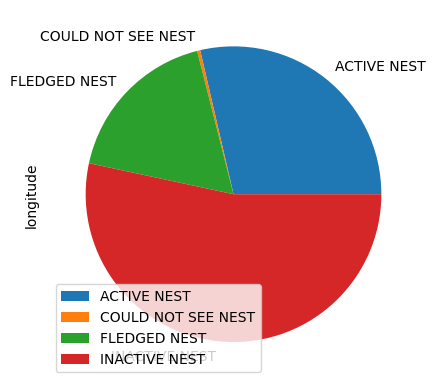

In [100]:
stat_count.plot.pie(y='longitude')

<AxesSubplot: xlabel='recentstat'>

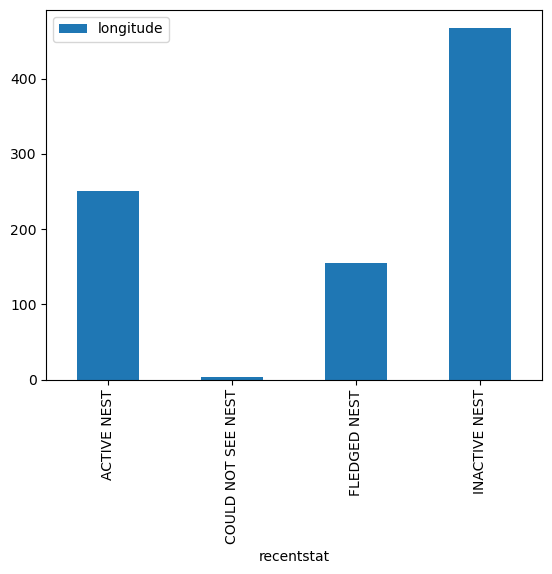

In [101]:
stat_count.plot.bar(y='longitude')